In [8]:
#! /usr/bin/python
# -*- coding: utf-8 -*-
# @author izhangxm
# Copyright 2017 izhangxm@gmail.com. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [9]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from itertools import product
import os.path as osp
from scipy.optimize import leastsq
import time
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
# from tqdm import tqdm, trange
from tqdm.notebook import  tqdm

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [10]:
from core_lib import MyDataset, r2_loss, get_target, plot_dataset
from core_lib import get_dcdts_for_scipy_odeint, get_dcdts_for_solve_ivp
from core_lib import MY_EPSILON
from core_lib import set_pbar_start


/Users/izhangxm/WorkStation/VSCode/N15Tracing/core_lib/data.py:225: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


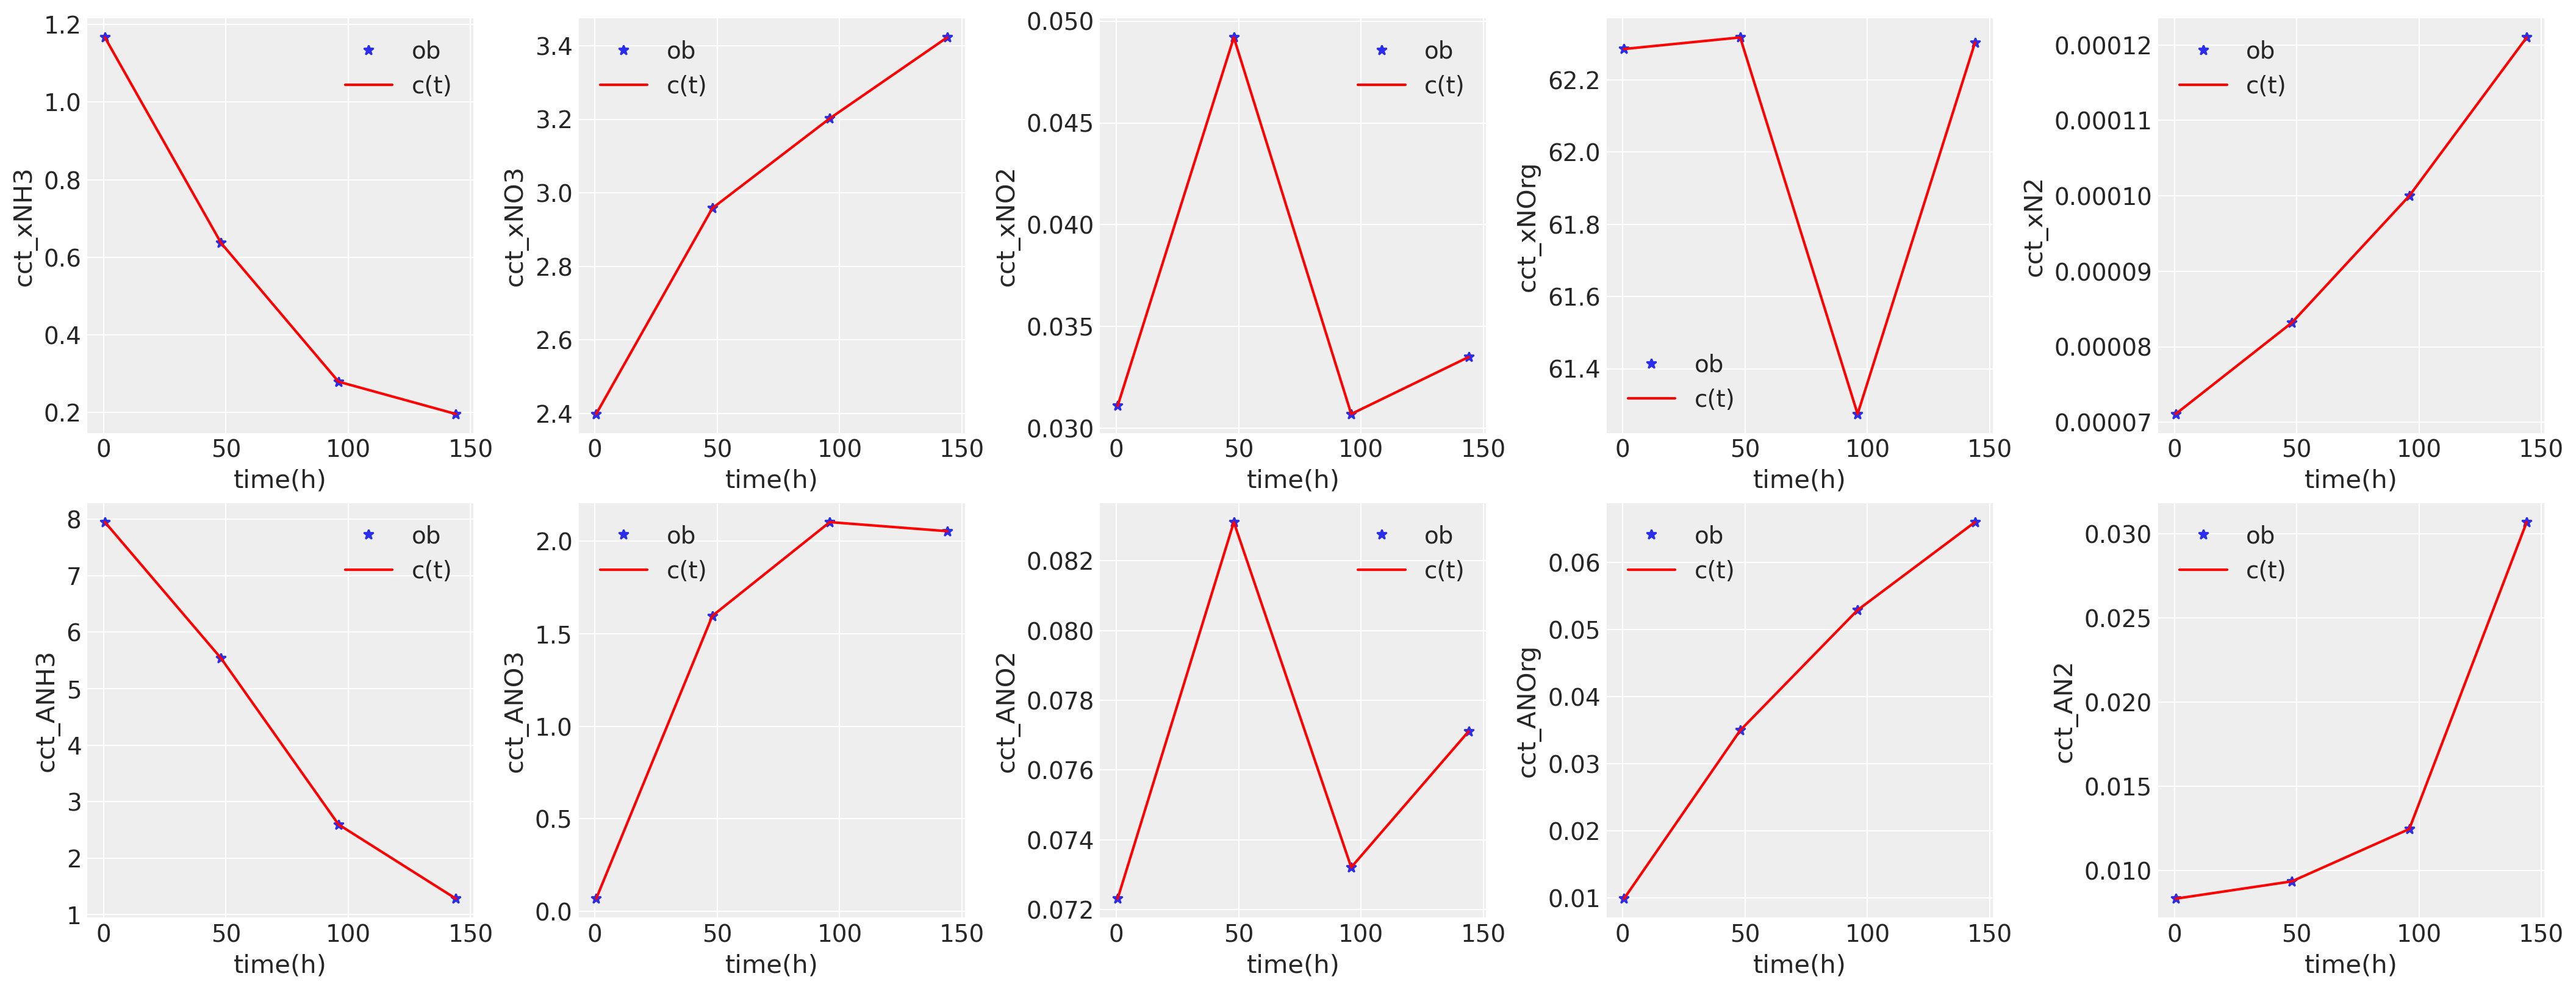

In [11]:

db_csv_path = "dataset/data.csv"
dataset = MyDataset(db_csv_path)
df = dataset.get_df()
cct_names, rates_names, error_names = dataset.get_var_col_names()
c0 = df[cct_names].iloc[0].values
t_eval = dataset.get_df()['time'].values

# # 假设都是一级动力学
# k_kinetics = np.repeat(1, 11).astype(np.uint8)
# ## k_kinetics = np.array([0,0,0,0,1,1,0,0,1,1,0]).astype(np.uint8)
# ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
# dataset.set_as_sim_dataset(t_eval, c0, t0=0.5, args=(ks, k_kinetics))
# df = dataset.get_df()

plot_dataset(dataset, dataset)



In [12]:

def ltq_fit_rk(dataset, t_eval, c0,   k_kinetics, maxfev=2400, plot_trace=False, show_process=True, pbar=None, pbar_prefix=""):

    ee = np.array(MY_EPSILON)
    
    def _error_loss(ks, *args):
        dataset, c0, t_eval, pbar,loss_trace,r2_trace, ks_trace, pbar_prefix = args
        #------------------------
        cct_names, rates_names, error_names = dataset.get_var_col_names()
        df = dataset.get_df()
        timelist = df['time'].values
        ccts = dataset.get_cct()
        #------------------------

        sol_res = solve_ivp(get_dcdts_for_solve_ivp(), (t_eval.min(), t_eval.max()), c0, t_eval=t_eval, method='Radau', args=(ks, k_kinetics))
        # sol_res = solve_ivp(get_dcdts_for_solve_ivp(), (t_eval.min(), t_eval.max()), c0, t_eval=t_eval, method='BDF', args=(ks, k_kinetics))
        # sol_res = solve_ivp(get_dcdts_for_solve_ivp(), (t_eval.min(), t_eval.max()), c0, t_eval=t_eval, method='DOP853', args=(ks, k_kinetics))
        cs = sol_res.y
        t_eval = sol_res.t

        # res = odeint(func=get_dcdts_for_scipy_odeint(), y0=c0, t=t_eval, args=(ks,k_kinetics))
        # cs = np.transpose(res, [1,0])

        ccts_predict = []
        for _t, cctsob_at_t in zip(timelist, ccts):
            _i = np.argwhere(t_eval == _t)
            if len(_i) > 0:
                _i = int(_i[0])
                cct_at_t = cs[:, _i]
            else:
                cct_at_t = -cctsob_at_t * 10

            ccts_predict.append(cct_at_t)

        ccts_predict = np.array(ccts_predict)

        loss = (np.abs(ccts - ccts_predict) * ee ).reshape(-1)
        r2_all = r2_loss(ccts, ccts_predict)
        loss_sum = loss.sum()

        _var_r2s = []
        for _cct_pre, _cct_y in zip(np.transpose(ccts_predict, [1, 0]), np.transpose(ccts, [1, 0]), ):
            _r2 = r2_loss(_cct_pre, _cct_y)
            _var_r2s.append(_r2)
        _var_r2s = np.array(_var_r2s)

        _var_r2s_s = [f"{_c}:{x:.04f}" for x, _c in zip(_var_r2s, cct_names)]
        _r2s_str = ",".join(_var_r2s_s)


        r2_dict = {"r2_all":r2_all, "r2_detail":_var_r2s}

        if pbar:
            # p_str = f"r2_all:{r2_all:.04f} {_r2s_str}, loss_sum:{loss_sum:.04f}"
            p_str = f"r2_all:{r2_all:.04f} , loss_sum:{loss_sum:.04f} r2_mean:{_var_r2s.mean():.04f}"
            pbar.set_description(f"{pbar_prefix}{p_str}")
            pbar.update(1)
            pbar.refresh()

        loss_trace.append(loss_sum)
        r2_trace.append(r2_dict)
        ks_trace.append(ks)

        return loss


    loss_trace = []
    r2_trace = []
    ks_trace = []


    if show_process:
        if pbar is None:
            pbar =tqdm(total=maxfev, ascii=True)
        else:
            pbar.reset(total=maxfev)
            set_pbar_start(pbar=pbar, n=0)
    else:
        pbar = None

    ks_o = np.repeat(0.0001, 11).tolist()
    ks_res = leastsq(_error_loss, ks_o, maxfev=maxfev, args=(dataset, c0, t_eval, pbar,loss_trace,r2_trace, ks_trace, pbar_prefix),ftol=1.49012e-8, xtol=1.49012e-8)[0]

    if plot_trace:
        X = range(len(loss_trace))

        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
        axes[0].plot(X, loss_trace, alpha=0.6)
        axes[1].plot(X, r2_trace['r2_all'], alpha=0.6)
        axes[0].set_xlabel("iters")
        axes[0].set_ylabel("loss_sum")
        axes[1].set_xlabel("iters")
        axes[1].set_ylabel("r2")

        ks_trace = np.transpose(np.array(ks_trace), [1, 0])
        for _ks in ks_trace:
            axes[2].plot(X, _ks, alpha=0.6)

    return ks_res, r2_trace


In [13]:
k_kinetics = np.repeat(1, 11).astype(np.uint8)

t_eval = dataset.get_df()['time'].values
c0 = df[cct_names].iloc[0].values
ks_res, r2_trace = ltq_fit_rk(dataset,t_eval, c0, k_kinetics, maxfev=5000)


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import os

def research_kk_list(kk_list_all, res_dict_save_path, bad_keys=[]):
    # 保存计算的结果，并载入已经计算的结果
    res_dict = {}
    
    
    if os.path.exists(res_dict_save_path):
        res_dict = torch.load(res_dict_save_path)
    # 保存的间隔
    save_iter = 2
    n = len(res_dict.keys())

    # 需要遍历的模型组合
    # kk_list_all = [list(x) for x in product([0,1], repeat=11)]
    # 反向计算序列，从最大的可能性开始计算
    # kk_list_all = kk_list_all[::-1]
    
    # 总进度条和子进度条
    pbar =tqdm(total=len(kk_list_all), ascii=True)
    sub_bar = tqdm(total=len(kk_list_all), ascii=True)

    # 总进度条恢复进度
    pbar = set_pbar_start(pbar, n)

    

    # 循环计算
    for ii, k_kinetics in enumerate(kk_list_all):
        key = "".join([f"{_}" for _ in k_kinetics])
        if key in res_dict or key in bad_keys:
            continue
        
        pbar.set_description(f"total progress: {key}")
        pbar.update(1)
        pbar.refresh()
        
        ks_res, r2_trace = ltq_fit_rk(dataset,t_eval, c0, k_kinetics, maxfev=3000, plot_trace=False, show_process=True, pbar=sub_bar)
        # _dd = r2_trace[-1]['r2_detail']
        # r2_mean = _dd.mean()
        # r2_all = r2_trace[-1]['r2_all']
        # _t = k_kinetics + list(_dd) + [r2_mean, r2_all]
        
        res_dict[key] = {"ks_res":ks_res, "r2_trace_lastest":r2_trace[-1]}
        
        if ii % save_iter == 0:
            torch.save(res_dict, res_dict_save_path)

    # r2_all = np.array(r2_all_list)
    # dfr2 = pd.DataFrame(r2_all, columns=[ f"k{x+1}" for x  in range(11) ] + [f'r2_{c}' for c in cct_names] + ["r2_mean", "r2_all"])
    # dfr2.to_csv("runtime/r2_all_v2.csv")

    torch.save(res_dict, res_dict_save_path)
    return res_dict


In [ ]:

kk_list_all = [
    [0,1,1,1,1,1,1,1,1,0,1],
    [0,1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,0,1],
    [1,1,1,1,1,1,1,1,1,1,1],
    ]
rr = research_kk_list(kk_list_all, "runtime/lsq_res_dict_possible.pt");
for key, v in rr.items():
    print(key, v)



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

01111111101 {'ks_res': array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001]), 'r2_trace_lastest': {'r2_all': -0.3254220328631472, 'r2_detail': array([-1.07205327e+02, -6.37893512e+03, -2.33305073e+03, -1.76207090e+06,
       -2.71546443e+03, -1.74923591e+02, -4.96623353e+02, -3.04261765e+04,
       -5.70635836e+02, -4.34465047e+02])}}
01111111111 {'ks_res': array([9.99994160e-05, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000586e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04]), 'r2_trace_lastest': {'r2_all': -0.3254220328631472, 'r2_detail': array([-1.07205327e+02, -6.37893512e+03, -2.33305073e+03, -1.76207090e+06,
       -2.71546443e+03, -1.74923591e+02, -4.96623353e+02, -3.04261765e+04,
       -5.70635836e+02, -4.34465047e+02])}}
11111111101 {'ks_res': array([-1.39893717e-03,  5.25209385e-07, -2.27530075e-03, -1.39066617e-05,
        1.62551271e-04, -1.38657907

In [ ]:
kk_list_all = [list(x) for x in product([0,1], repeat=11)]
kk_list_all = kk_list_all[::-1]
bad_keys = ["11011010101", "10010100001", "01111011010","01111010110", "01111010101","01111001101"]

research_kk_list(kk_list_all, "runtime/lsq_res_dict.pt", bad_keys=bad_keys)


In [ ]:
# ks_res, r2_trace = ltq_fit_rk(dataset, t_eval, c0, k_kinetics, maxfev=5000, plot_trace=False, show_process=True, pbar=None)

dcdt_func = get_dcdts_for_solve_ivp()


ks = ks_res
res = solve_ivp(get_dcdts_for_solve_ivp(), (t_eval.min(), t_eval.max()), c0, method='Radau', t_eval=t_eval, args=(ks, k_kinetics))
cs = res.y
t_eval = res.t


# res = odeint(func=get_dcdts_for_scipy_odeint(), y0=c0, t=t_eval, args=(ks,k_kinetics))
# cs = np.transpose(res, [1,0])

# 计算导数曲线
derivative = []
# 10*150
dcdt_df = pd.DataFrame(columns=['time'] + cct_names)


for i, t in enumerate(t_eval):
    cct = cs[:, i]
    dcdts = dcdt_func(t, cct, ks, k_kinetics)
    dcdt_df.loc[len(dcdt_df.index)] = [t] + list(dcdts)

cols = 5
rows = math.ceil(len(cct_names) / cols)

fig, fig_axes = plt.subplots(ncols=cols, nrows=rows, figsize=(4.2 * cols, 4 * rows), dpi=100)
if isinstance(fig_axes, np.ndarray):
    fig_axes = fig_axes.reshape(-1)
else:
    fig_axes = [fig_axes]

for i, axes in enumerate(fig_axes):
    if i >= len(cct_names):
        axes.axis('off')
        continue

    y_name = cct_names[i]
    Y = df[y_name].values
    axes.plot(df['time'].values, Y, '*', label=f"ob")
    axes.set_ylabel(f'cct_{y_name}')
    axes.set_xlabel(f'time(h)')

    # axes.plot(df['time'].values, df[rates_names[i]].values, '+', label=f"rate")

    axes.plot(t_eval, cs[i, :], 'r', label=f"c(t)")
    # axes.plot(t_eval, dcdt_df[y_name].values,'g', label=f"c'(t)")

    axes.legend()
    # axes.set_title(f"{y_name}", fontsize=14)

plt.tight_layout()
plt.show()

